## Notebook prepared for Google Colab

In [1]:
#Subir zip fotos y plotcm
from google.colab import files

uploaded = files.upload()

Saving MIT-CBCL.zip to MIT-CBCL.zip
Saving plotcm.py to plotcm.py


In [0]:
! unzip MIT-CBCL.zip

In [3]:
! ls

MIT-CBCL  MIT-CBCL.zip	plotcm.py  sample_data


# Face identification

### Inport needed libraries

For clarity, and to avoid problems, firstly include all needed libraries at the begining of the notebook. Import all needed libraries.

In [4]:
# Import general purpose python libraries
import os
import matplotlib.pyplot as plt
from PIL import Image # For handling the images
import numpy as np
from sklearn import metrics
# Import different Keras functionalities
import keras
from keras.applications import vgg16, ResNet50
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, concatenate
from keras.constraints import maxnorm
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils

import tensorflow as tf

# Import function to plot the confussion matrix
import plotcm

import keras.backend.tensorflow_backend as K2

Using TensorFlow backend.


In [0]:
config = tf.ConfigProto()
# ask for GPU memory gracefully
config.gpu_options.allow_growth = True

sess = tf.Session(config=config)

K2.set_session(sess)

### Database samples

The face database is in folder "MIT-CBCL". Database images are split into "train", "test", and "val", folders. Each of those three folders is composed of 10 different folders, each of those folders contains images of each subject. Images do not have the same size but most of them are close to 150x150 pixels. With the next lines you can see a sample image of each subject in the training folder.

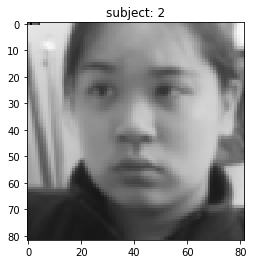

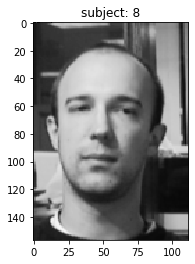

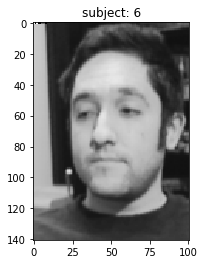

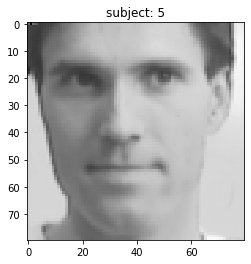

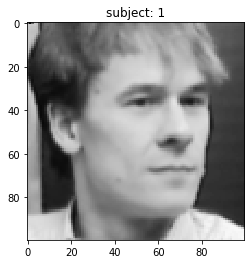

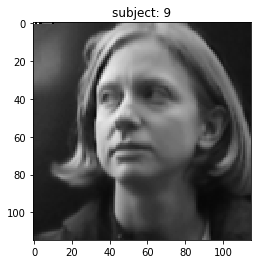

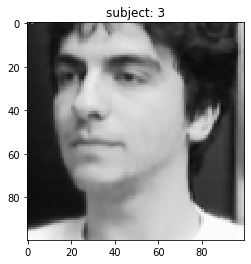

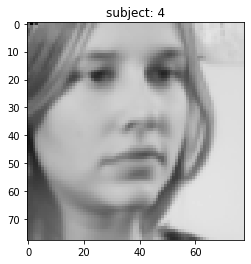

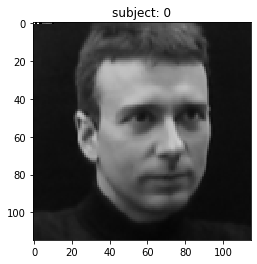

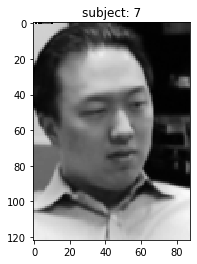

In [6]:
path_subjects = "./MIT-CBCL/train"
for i in os.listdir(path_subjects):
    count = 0
    for j in os.listdir(path_subjects + '/' + str(i)):
        if count==0:
            count = 1
            img = Image.open(path_subjects + '/' + str(i) + '/' + str(j))
            plt.imshow(img, cmap='gray', vmin=0, vmax=255)
            plt.title('subject: ' + str(i))
            plt.show()

### Configuration parameters
Configuration values of different parts of the solution. You should change some of them to obtain better results.

In [0]:
# Randomize the initial network weights
random_seed = True

# Parameters that characterizes the images, size and image type
img_width = 150
img_height = 150
img_mode = "grayscale" #Load mode for images, either rgb or grayscale. In our case although some images could be rgb,
                       #we are going to work with grayscale images

# Parameters that configures the training process
batch_size = 32 # Batch size
epochs = 37 # Number of epochs
initial_epoch = 0 # Initial epoch, it can be greater than 0 if you want to contiue a previous training process
initial_lr = 1e-5
decay = 1e-6
# Learning rate
opt = Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, amsgrad=True)

# Paths to where training, testing, and validation images are
database_dir = './MIT-CBCL'
train_dir = './MIT-CBCL/train'
val_dir = './MIT-CBCL/val'
test_dir = './MIT-CBCL/test'

# Directory where to store weights of the model and results
experiment_rootdir = "./test/"
# Create experiment directory if it does not exists
if not os.path.exists(experiment_rootdir):
    os.makedirs(experiment_rootdir)

weights_path = "weights.h5" # Name of the file to store the weights

# Output dimension (number of sublects in our problem)
num_classes = 10

# Name of each gesture of the database
CLASSES = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

# Training process

### Create the model
Here you should introduce your solution for the model that obtains better results.

In [0]:
def getModel(img_width, img_height, img_channels, output_dim, weights_path):

    dropout=0.25

    # Define the input shape indicating the width, heigh, and depth of the images
    input_shape = (img_width, img_height, img_channels)
    
    # Create the model itself
    model = Sequential()
    model.add(ResNet50(input_shape=input_shape, include_top = True, 
                       pooling = 'max', weights = None, classes=output_dim))
    # Say not to train first layer (ResNet) model as it is already trained
    # model.layers[0].trainable = False

    # Load pretrained model if it exists
    if weights_path:
        try:
            model.load_weights(weights_path)
            print("Loaded model from {}".format(weights_path))
        except:
            print("Impossible to find weight path. Returning untrained model")

    # Return the model itself
    return model

### Set model training process
Includes the compiles, which you can modify, a callback to just save the model if the validation loss decreases, and fits the model.

In [0]:
def trainModel(train_data_generator, val_data_generator, model, initial_epoch, batch_size, epochs):

    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    print(model.summary())
    # Define training and validation steps taking into account the number of samples for each process and the batch size
    steps_per_epoch = train_data_generator.samples // batch_size
    validation_steps = val_data_generator.samples // batch_size
    # Fit the model by using the fit generator
    history = model.fit_generator(train_data_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=1, 
                                  callbacks=None, validation_data=val_data_generator, validation_steps=validation_steps, 
                                  validation_freq=1, class_weight=None, max_queue_size=10, 
                                  workers=1, use_multiprocessing=False, shuffle=True, initial_epoch=initial_epoch)
    # Return the history of the model to plot the loss and accuracy evolution
    return history

### Load training and validation data
Loads training and validation data in a DataGenerator which divides the data in batches and prepares it for the training process.

In [10]:
# Set random seed
if random_seed:
    seed = np.random.randint(0,2*31-1)
else:
    seed = 5
np.random.seed(seed)
tf.set_random_seed(seed)

# Select the number of channels of the image considering the image mode (RGB or grayscale)
if img_mode=='rgb':
    img_channels = 3
elif img_mode == 'grayscale':
    img_channels = 1
else:
    raise IOError("Unidentified image mode: use 'grayscale' or 'rgb'")

# Create train_datagenerator using ImageDataGenerator of keras.
train_data_gen = ImageDataGenerator(rescale=1./255)

# Iterator object containing training data to be generated batch by batch
train_generator = train_data_gen.flow_from_directory(
        train_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        shuffle = True,
        color_mode = img_mode,
        class_mode='categorical',
        seed=seed)

# Check if the number of classes in dataset corresponds to the one specified                                                    
assert train_generator.num_classes == num_classes, \
                    " Not macthing output dimensions in training data."                                                    

# Create val_datagenerator using ImageDataGenerator of keras.
val_data_gen = ImageDataGenerator(rescale=1./255)

# Iterator object containing validation data to be generated batch by batch
val_generator = val_data_gen.flow_from_directory(
        val_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        shuffle = True,
        color_mode = img_mode,
        class_mode='categorical',
        seed=seed)

# Check if the number of classes in dataset corresponds to the one specified
assert val_generator.num_classes == num_classes, \
                    " Not macthing output dimensions in validation data."

Found 1200 images belonging to 10 classes.
Found 400 images belonging to 10 classes.


### Obtain and train the model itself
Load the model that you have specificly created and trains it

In [11]:
# Create the model by using the getModel function
model = getModel(img_width, img_height, img_channels, num_classes, weights_path)
# Train the model by using the trainModel function
history = trainModel(train_generator, val_generator, model, initial_epoch, batch_size, epochs)
# Save weights that can be used in future training process
weights_save_path = os.path.join(experiment_rootdir, weights_path)
model.save_weights(weights_save_path)












Impossible to find weight path. Returning untrained model


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 10)                23601930  
Total params: 23,601,930
Trainable params: 23,548,810
Non-trainable params: 53,120
_________________________________________________________________
None
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/37
37/37 [==============================] - 27s 734ms/step - loss: 1.7120 - acc: 0.4644 - val_loss: 1.0440 - val_acc: 0.7188
Epoch 2/37
37/37 [==============================] - 6s 157ms/step - loss: 0.7055 - acc: 0.8547 - val_loss: 0.5286 - val_acc: 0.9022
Epoch 3/37
37/37 [==============================] - 6s 158ms/step - loss: 0.3171 - acc: 0.9409 - val_loss: 0.3577 - val_acc: 0.9076
Epoch 4/37
37/37 [==============================] - 6s 156ms/s

# Testing

### Predictions computation
Function to obtain the predictions over the testing data, it also outputs the ground truth of the input data

### Load testing data

In [12]:
# Create test_datagenerator using ImageDataGenerator of keras.
test_data_gen = ImageDataGenerator(rescale=1./255)

# Iterator object containing validation data to be generated batch by batch
test_generator = test_data_gen.flow_from_directory(
        test_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        shuffle = False,
        color_mode = img_mode,
        class_mode='categorical',
        seed=seed)

# Check if the number of classes in dataset corresponds to the one specified
assert test_generator.num_classes == num_classes, \
                    " Not macthing output dimensions in test data."

Found 400 images belonging to 10 classes.


### Testing process
Load the model, load the weight obtained by the training process, obtain testing results and plot those results in a confusion matrix.

Loaded model from ./test/weights.h5
(384, 10)
-----------------------------------------------
Evaluation:
Average accuracy =  1.0
-----------------------------------------------


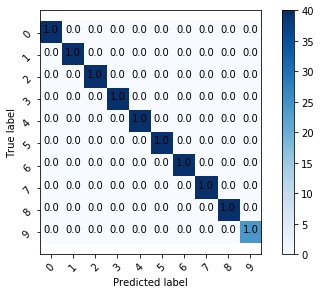

In [13]:
# Create the model by using the getModel function
model = getModel(img_width, img_height, img_channels, num_classes, None)
# Load saved weights
weights_load_path = os.path.join(experiment_rootdir, weights_path)

try:
    model.load_weights(weights_load_path)
    print("Loaded model from {}".format(weights_load_path))
except:
    print("Impossible to find weight path. Returning untrained model")


# Compile model
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# Get predictions using predict_generator function
steps_test = test_generator.samples // batch_size
results = model.predict_generator(test_generator, steps=steps_test, callbacks=None, 
                                  max_queue_size=10, workers=1, use_multiprocessing=False, 
                                  verbose=0)
# Select the class which has the higher predicted value
print(results.shape)
pred_labels = np.zeros((results.shape[0],1))
pred_labels = np.argmax(results,axis=1).reshape(-1,1)

# Create groundtruth
gt = np.zeros(pred_labels.shape)
init_index = 0
end_index = 0
user_id = 0
for users in sorted(os.listdir(test_dir)):
    user_id = user_id + 1
    if os.path.isdir(os.path.join(test_dir, users)):
        user_path = os.path.join(test_dir, users)
        for root, _, files in sorted(os.walk(user_path)):
            num_images_user = len(files)
            end_index = init_index + num_images_user
            gt[init_index:end_index] = user_id - 1
            init_index = end_index
            
# Evaluate predictions: Average accuracy and highest errors
print("-----------------------------------------------")
print("Evaluation:")
# Compute average accuracy
ave_accuracy = metrics.accuracy_score(gt, pred_labels)
print('Average accuracy = ', ave_accuracy)
print("-----------------------------------------------")

# Visualize confusion matrix                                           
plotcm.plotcm(experiment_rootdir, gt, pred_labels,CLASSES, experiment_rootdir, normalize=True)

### Plot history for accuracy for training and validation process

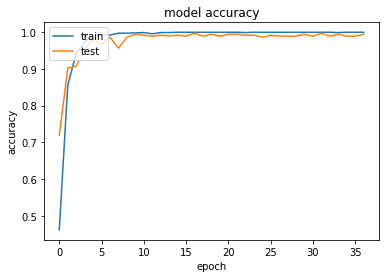

In [14]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Save the figure
plt.savefig("Accuracy.png")

# Show figure
plt.show()

### Plot history for loss for training and validation process

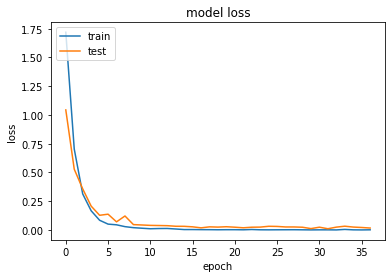

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Save the figure
plt.savefig("Loss.png")

# Show figure
plt.show()